# Memorizing Models for Synthetic Data Generation

## Adult Census Income Dataset from https://archive.ics.uci.edu/dataset/2/adult

In [106]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression as sklearn_logreg
from diffprivlib.models import LogisticRegression as dp_logreg
from sklearn.naive_bayes import GaussianNB as sklearn_gnb
from diffprivlib.models import GaussianNB as dp_gnb
from sklearn.tree import DecisionTreeClassifier as sklearn_dt
from diffprivlib.models import DecisionTreeClassifier as dp_dt
from sklearn.ensemble import RandomForestClassifier as sklearn_rf
from diffprivlib.models import RandomForestClassifier as dp_rf
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [112]:
df = pd.read_csv("adult.csv")
df.head()

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,90,?,77053,HS-grad,9,Widowed,?,Not-in-family,White,Female,0,4356,40,United-States,<=50K
1,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,<=50K
2,66,?,186061,Some-college,10,Widowed,?,Unmarried,Black,Female,0,4356,40,United-States,<=50K
3,54,Private,140359,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States,<=50K
4,41,Private,264663,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,<=50K


In [113]:
df[df == '?'] = np.nan
for col in ['workclass', 'occupation', 'native.country']:
    df[col].fillna("other", inplace=True)

df.isnull().values.any()

False

In [114]:
categorical_cols = ["workclass", "education", "marital.status", "occupation", "relationship", "race", "sex"]
df = pd.get_dummies(df, columns=categorical_cols, dtype=int, drop_first=True)
df = df.drop("native.country", axis=1)
df["income"] = pd.factorize(df["income"])[0]
income_col = df.pop("income")
df.insert(len(df.columns), "income", income_col)
df.describe(include='all')

,age,fnlwgt,education.num,capital.gain,capital.loss,hours.per.week,workclass_Local-gov,workclass_Never-worked,workclass_Private,workclass_Self-emp-inc,...,relationship_Other-relative,relationship_Own-child,relationship_Unmarried,relationship_Wife,race_Asian-Pac-Islander,race_Black,race_Other,race_White,sex_Male,income
count,32561.000000,3.256100e+04,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,...,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000
mean,38.581647,1.897784e+05,10.080679,1077.648844,87.303830,40.437456,0.064279,0.000215,0.697030,0.034274,...,0.030128,0.155646,0.105832,0.048156,0.031909,0.095943,0.008323,0.854274,0.669205,0.240810
std,13.640433,1.055500e+05,2.572720,7385.292085,402.960219,12.347429,0.245254,0.014661,0.459549,0.181935,...,0.170942,0.362525,0.307627,0.214099,0.175761,0.294518,0.090851,0.352837,0.470506,0.427581
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,28.000000,1.178270e+05,9.000000,0.000000,0.000000,40.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
50%,37.000000,1.783560e+05,10.000000,0.000000,0.000000,40.000000,0.000000,0.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000
75%,48.000000,2.370510e+05,12.000000,0.000000,0.000000,45.000000,0.000000,0.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000
max,90.000000,1.484705e+06,16.000000,99999.000000,4356.000000,99.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [115]:
df = df.set_index("age")

In [116]:
df.head()

,fnlwgt,education.num,capital.gain,capital.loss,hours.per.week,workclass_Local-gov,workclass_Never-worked,workclass_Private,workclass_Self-emp-inc,workclass_Self-emp-not-inc,...,relationship_Other-relative,relationship_Own-child,relationship_Unmarried,relationship_Wife,race_Asian-Pac-Islander,race_Black,race_Other,race_White,sex_Male,income
age,,,,,,,,,,,,,,,,,,,,,
90,77053,9,0,4356,40,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
82,132870,9,0,4356,18,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
66,186061,10,0,4356,40,0,0,0,0,0,...,0,0,1,0,0,1,0,0,0,0
54,140359,4,0,3900,40,0,0,1,0,0,...,0,0,1,0,0,0,0,1,0,0
41,264663,10,0,3900,40,0,0,1,0,0,...,0,1,0,0,0,0,0,1,0,0


In [118]:
df.to_csv("adult_clean.csv")

In [45]:
!brainome adult_clean.csv -o adult_clean.py -e 5 -y

/Users/aneesh/opt/anaconda3/lib/python3.8/site-packages/xgboost/compat.py:31: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
Brainome Table Compiler v2.0-172-prod
Copyright (c) 2019-2022 Brainome, Inc. All Rights Reserved.
Licensed to:                 Demo User  (Evaluation)
Expiration Date:             2025-12-31   617 days left
Maximum File Size:           30 GB
Maximum Instances:           unlimited
Maximum Attributes:          unlimited
Maximum Classes:             unlimited
Connected to:                daimensions.brainome.ai  (local execution)

Command:
    brainome adult_clean.csv -o adult_clean.py -e 5 -y

Start Time:                 04/23/2024, 11:49 PDT

 ing...Splitting into training and validation...Pre-training measurements...

Pre-training Measurements
Data:
    Input:                      adult_clean.csv
    Target Column: 

In [46]:
!brainome adult_clean.csv -nosplit -f DT -o adult_clean_mm.py -y -biasmeter

/Users/aneesh/opt/anaconda3/lib/python3.8/site-packages/xgboost/compat.py:31: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
Brainome Table Compiler v2.0-172-prod
Copyright (c) 2019-2022 Brainome, Inc. All Rights Reserved.
Licensed to:                 Demo User  (Evaluation)
Expiration Date:             2025-12-31   617 days left
Maximum File Size:           30 GB
Maximum Instances:           unlimited
Maximum Attributes:          unlimited
Maximum Classes:             unlimited
Connected to:                daimensions.brainome.ai  (local execution)

Command:
    brainome adult_clean.csv -nosplit -f DT -o adult_clean_mm.py -y -biasmeter

Start Time:                 04/23/2024, 11:56 PDT

 ing...Splitting into training and validation...Pre-training measurements...

Pre-training Measurements
Data:
    Input:                      adult_clean

In [57]:
!python3 synthesize.py adult_clean.csv 200000 >adult_clean_synth.csv

In [58]:
!python3 adult_clean_mm.py adult_clean_synth.csv > adult_clean_synth_labelled.csv

In [59]:
!brainome adult_clean_synth_labelled.csv -o adult_clean_synth_labelled.py -e 5 -y

/Users/aneesh/opt/anaconda3/lib/python3.8/site-packages/xgboost/compat.py:31: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
Brainome Table Compiler v2.0-172-prod
Copyright (c) 2019-2022 Brainome, Inc. All Rights Reserved.
Licensed to:                 Demo User  (Evaluation)
Expiration Date:             2025-12-31   617 days left
Maximum File Size:           30 GB
Maximum Instances:           unlimited
Maximum Attributes:          unlimited
Maximum Classes:             unlimited
Connected to:                daimensions.brainome.ai  (local execution)

Command:
    brainome adult_clean_synth_labelled.csv -o adult_clean_synth_labelled.py -e 5 -y

Start Time:                 04/23/2024, 12:08 PDT

 ing...Splitting into training and validation...Pre-training measurements...

Pre-training Measurements
Data:
    Input:                      adult

In [60]:
!python3 adult_clean.py adult_clean.csv -validate | grep "Improvement"

    Improvement over best guess:    8.36% (of possible 24.08%)


In [61]:
!python3 adult_clean_synth_labelled.py adult_clean.csv -validate | grep "Improvement"

    Improvement over best guess:    -0.01% (of possible 24.08%)


## Breast Cancer Dataset from https://archive.ics.uci.edu/dataset/17/breast+cancer+wisconsin+diagnostic

In [138]:
from sklearn.datasets import load_breast_cancer
bc_data = load_breast_cancer()
bc_df = pd.DataFrame(np.c_[bc_data['data'], bc_data['target']], columns= np.append(bc_data['feature_names'], ['target']))
bc_df.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0.0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0.0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0.0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0.0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0.0


In [120]:
bc_df.isnull().values.any()

False

In [140]:
bc_df = bc_df.set_index("mean radius")
bc_df.head()

,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,radius error,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
mean radius,,,,,,,,,,,,,,,,,,,,,
17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,1.0950,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0.0
20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0.0
19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,0.7456,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0.0
11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,0.4956,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0.0
20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,0.7572,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0.0


In [141]:
bc_df.to_csv("wdbc_clean.csv")

In [142]:
!brainome wdbc_clean.csv -o wdbc_clean.py -e 5 -y

/Users/aneesh/opt/anaconda3/lib/python3.8/site-packages/xgboost/compat.py:31: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
Brainome Table Compiler v2.0-172-prod
Copyright (c) 2019-2022 Brainome, Inc. All Rights Reserved.
Licensed to:                 Demo User  (Evaluation)
Expiration Date:             2025-12-31   609 days left
Maximum File Size:           30 GB
Maximum Instances:           unlimited
Maximum Attributes:          unlimited
Maximum Classes:             unlimited
Connected to:                daimensions.brainome.ai  (local execution)

Command:
    brainome wdbc_clean.csv -o wdbc_clean.py -e 5 -y

Start Time:                 05/01/2024, 14:08 PDT

 ing...Splitting into training and validation...Pre-training measurements...

Pre-training Measurements
Data:
    Input:                      wdbc_clean.csv
    Target Column:    

In [143]:
!brainome wdbc_clean.csv -nosplit -f DT -o wdbc_clean_mm.py -y -biasmeter

/Users/aneesh/opt/anaconda3/lib/python3.8/site-packages/xgboost/compat.py:31: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
Brainome Table Compiler v2.0-172-prod
Copyright (c) 2019-2022 Brainome, Inc. All Rights Reserved.
Licensed to:                 Demo User  (Evaluation)
Expiration Date:             2025-12-31   609 days left
Maximum File Size:           30 GB
Maximum Instances:           unlimited
Maximum Attributes:          unlimited
Maximum Classes:             unlimited
Connected to:                daimensions.brainome.ai  (local execution)

Command:
    brainome wdbc_clean.csv -nosplit -f DT -o wdbc_clean_mm.py -y -biasmeter

Start Time:                 05/01/2024, 14:11 PDT

 ing...Splitting into training and validation...Pre-training measurements...

Pre-training Measurements
Data:
    Input:                      wdbc_clean.cs

In [144]:
!python3 synthesize.py wdbc_clean.csv 200000 >wdbc_clean_synth.csv

In [145]:
!python3 wdbc_clean_mm.py wdbc_clean_synth.csv > wdbc_clean_synth_labelled.csv

In [146]:
!brainome wdbc_clean_synth_labelled.csv -o wdbc_clean_synth_labelled.py -e 5 -y

/Users/aneesh/opt/anaconda3/lib/python3.8/site-packages/xgboost/compat.py:31: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
Brainome Table Compiler v2.0-172-prod
Copyright (c) 2019-2022 Brainome, Inc. All Rights Reserved.
Licensed to:                 Demo User  (Evaluation)
Expiration Date:             2025-12-31   609 days left
Maximum File Size:           30 GB
Maximum Instances:           unlimited
Maximum Attributes:          unlimited
Maximum Classes:             unlimited
Connected to:                daimensions.brainome.ai  (local execution)

Command:
    brainome wdbc_clean_synth_labelled.csv -o wdbc_clean_synth_labelled.py -e 5 -y

Start Time:                 05/01/2024, 14:13 PDT

 ing...Splitting into training and validation...Pre-training measurements...

Pre-training Measurements
Data:
    Input:                      wdbc_cl

In [147]:
!python3 wdbc_clean.py wdbc_clean.csv -validate | grep "Improvement"

    Improvement over best guess:    33.74% (of possible 37.26%)


In [148]:
!python3 wdbc_clean_synth_labelled.py wdbc_clean.csv -validate | grep "Improvement"

    Improvement over best guess:    -25.49% (of possible 37.26%)


## Handwritten Digits Dataset

In [157]:
from sklearn.datasets import load_digits
d_data = load_digits()
d_df = pd.DataFrame(np.c_[d_data['data'], d_data['target']], columns= np.append(d_data['feature_names'], ['target']))
d_df.head()

,pixel_0_0,pixel_0_1,pixel_0_2,pixel_0_3,pixel_0_4,pixel_0_5,pixel_0_6,pixel_0_7,pixel_1_0,pixel_1_1,...,pixel_6_7,pixel_7_0,pixel_7_1,pixel_7_2,pixel_7_3,pixel_7_4,pixel_7_5,pixel_7_6,pixel_7_7,target
0,0.0,0.0,5.0,13.0,9.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,6.0,13.0,10.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,12.0,13.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,11.0,16.0,10.0,0.0,0.0,1.0
2,0.0,0.0,0.0,4.0,15.0,12.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,3.0,11.0,16.0,9.0,0.0,2.0
3,0.0,0.0,7.0,15.0,13.0,1.0,0.0,0.0,0.0,8.0,...,0.0,0.0,0.0,7.0,13.0,13.0,9.0,0.0,0.0,3.0
4,0.0,0.0,0.0,1.0,11.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,2.0,16.0,4.0,0.0,0.0,4.0


In [158]:
d_df.isnull().values.any()

False

In [160]:
d_df = d_df.set_index("pixel_0_0")

In [161]:
d_df.to_csv("digits_clean.csv")

In [163]:
!brainome digits_clean.csv -o digits_clean.py -e 5 -y

Python(41424) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


/Users/aneesh/opt/anaconda3/lib/python3.8/site-packages/xgboost/compat.py:31: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
Brainome Table Compiler v2.0-172-prod
Copyright (c) 2019-2022 Brainome, Inc. All Rights Reserved.
Licensed to:                 Demo User  (Evaluation)
Expiration Date:             2025-12-31   608 days left
Maximum File Size:           30 GB
Maximum Instances:           unlimited
Maximum Attributes:          unlimited
Maximum Classes:             unlimited
Connected to:                daimensions.brainome.ai  (local execution)

Command:
    brainome digits_clean.csv -o digits_clean.py -e 5 -y

Start Time:                 05/02/2024, 09:18 PDT

 ing...Splitting into training and validation...Pre-training measurements...

Pre-training Measurements
Data:
    Input:                      digits_clean.csv
    Target Colum

In [164]:
!brainome digits_clean.csv -nosplit -f DT -o digits_clean_mm.py -y -biasmeter

Python(41537) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


/Users/aneesh/opt/anaconda3/lib/python3.8/site-packages/xgboost/compat.py:31: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
Brainome Table Compiler v2.0-172-prod
Copyright (c) 2019-2022 Brainome, Inc. All Rights Reserved.
Licensed to:                 Demo User  (Evaluation)
Expiration Date:             2025-12-31   608 days left
Maximum File Size:           30 GB
Maximum Instances:           unlimited
Maximum Attributes:          unlimited
Maximum Classes:             unlimited
Connected to:                daimensions.brainome.ai  (local execution)

Command:
    brainome digits_clean.csv -nosplit -f DT -o digits_clean_mm.py -y -biasmeter

Start Time:                 05/02/2024, 09:24 PDT

 ing...Splitting into training and validation...Pre-training measurements...

Pre-training Measurements
Data:
    Input:                      digits_cl

In [168]:
!python3 synthesize.py digits_clean.csv 200000 >digits_clean_synth.csv

Python(41607) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


In [169]:
!python3 digits_clean_mm.py digits_clean_synth.csv > digits_clean_synth_labelled.csv

Python(41673) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


In [170]:
!brainome digits_clean_synth_labelled.csv -o digits_clean_synth_labelled.py -e 5 -y

Python(41677) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


/Users/aneesh/opt/anaconda3/lib/python3.8/site-packages/xgboost/compat.py:31: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
Brainome Table Compiler v2.0-172-prod
Copyright (c) 2019-2022 Brainome, Inc. All Rights Reserved.
Licensed to:                 Demo User  (Evaluation)
Expiration Date:             2025-12-31   608 days left
Maximum File Size:           30 GB
Maximum Instances:           unlimited
Maximum Attributes:          unlimited
Maximum Classes:             unlimited
Connected to:                daimensions.brainome.ai  (local execution)

Command:
    brainome digits_clean_synth_labelled.csv -o digits_clean_synth_labelled.py -e 5 -y

Start Time:                 05/02/2024, 09:32 PDT

 ing...Splitting into training and validation...Pre-training measurements...

Pre-training Measurements
Data:
    Input:                      dig

In [171]:
!python3 digits_clean.py digits_clean.csv -validate | grep "Improvement"

Python(42915) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


    Improvement over best guess:    86.87% (of possible 89.82%)


In [172]:
!python3 digits_clean_synth_labelled.py digits_clean.csv -validate | grep "Improvement"

Python(42918) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


    Improvement over best guess:    2.89% (of possible 89.82%)


## GRAPHS

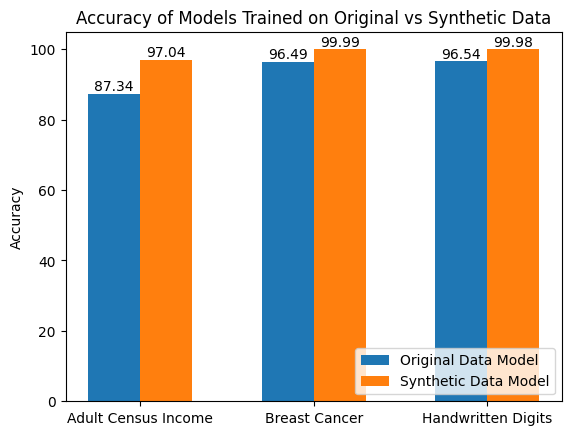

In [197]:
original_validation_accs = [87.34, 96.49, 96.54]
synthetic_validation_accs = [97.04, 99.99, 99.98]
ind = np.arange(3)
dfs = ["Adult Census Income", "Breast Cancer", "Handwritten Digits"]

b1 = plt.bar(ind, original_validation_accs, width=0.3, label="Original Data Model")
b2 = plt.bar(ind + 0.3, synthetic_validation_accs, width=0.3, label="Synthetic Data Model")
plt.xticks(ind + 0.3 / 2, ("Adult Census Income", "Breast Cancer", "Handwritten Digits"))
plt.bar_label(b1)
plt.bar_label(b2)
plt.legend(loc='lower right')
plt.ylabel("Accuracy")
plt.title("Accuracy of Models Trained on Original vs Synthetic Data");